<a href="https://colab.research.google.com/github/alexfc14/fancy-neural-networks/blob/master/Tree_Neuron_Connection_Designs_for_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tree Neuron Connection Designs for Churn Prediction

#### Summary

In this notebook we load and transform the dataset from Telco on for churn prediction and compare several  approaches:
 - Logistic Regression, comparing several choices for encoding and showing feature importances.
 - Other machine learning models like Random Forest, K-Nearest Neighbors, MLP.
 - Multilayer Perceptron in keras, fine tuned from no hidden layers to two layers of 50 and 15 neurons.
 - "Tree" Architecture in keras: a proposal to cut down the number of connections between columns of different groups.

#### Conclusions
 - Logistic Regression alone does very well, leaving small room for improvement to the more complex proposed models.

 - The approach scoring the highest is the multilayer perceptron with 50 and 15 neuron hidden layers, which is counter intuitive starting from 30 columns. Architectures usually work better by narrowing the previous layers. This means there are a lot of subtle interactions between variables. Such a large size also increases noise a lot, which makes it score lower if not trained manually.

 - The proposed "Tree" architecture scores second, and also becomes noisy if we increase its size. Still it is a good idea that may suit many problems and the code is built in a generic way from a dictionary of columns, so it can be reused for any other problem where both having some layer depth and avoiding overfitting are important.

As a nicety, an adapter of keras models (not only sequential) for sklearn cross_validate is provided.

### Exploratory Data Analysis



In [ ]:
!pip install wget
import wget
download_link='https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'
fname='data.csv'
wget.download(download_link,out=fname)

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=611150b581a250ca23e4ef366211a2861dc46cd62e8203f4151ec8431250b081
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


'data.csv'

In [ ]:
import pandas as pd
df=pd.read_csv(fname)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
len(df), len(df.columns)

(7043, 21)

In [ ]:
def to_float(s, default=0):
    result=default
    try:
        result = float(s)
    except:
        print(s, 'could not be converted to float, using default', default)
    return result

df.TotalCharges=df.TotalCharges.map(to_float)

  could not be converted to float, using default 0
  could not be converted to float, using default 0
  could not be converted to float, using default 0
  could not be converted to float, using default 0
  could not be converted to float, using default 0
  could not be converted to float, using default 0
  could not be converted to float, using default 0
  could not be converted to float, using default 0
  could not be converted to float, using default 0
  could not be converted to float, using default 0
  could not be converted to float, using default 0


0         29.85
1       1889.50
2        108.15
3       1840.75
4        151.65
         ...   
7038    1990.50
7039    7362.90
7040     346.45
7041     306.60
7042    6844.50
Name: TotalCharges, Length: 7043, dtype: float64

total charges is a float read as a string, except for nan, which is encoded as a space character, and corresponds to no tenure and thus no accumulated payments

Paper billing has payment method Mailed check more often, but it is a different concept

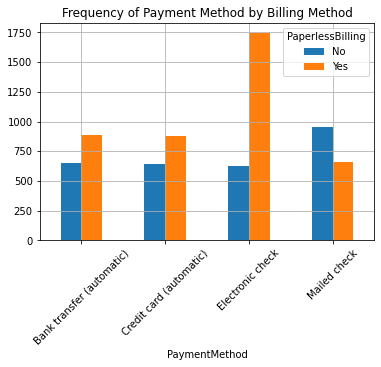

In [ ]:
df.PaymentMethod.groupby(df.PaperlessBilling).value_counts().unstack().T.plot.bar(rot=45, title='Frequency of Payment Method by Billing Method',grid=True)

Hypothesis: monthly charges much higher than past monthly charges provoque churn

    monthly charges > (total charges / tenure) => churn


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


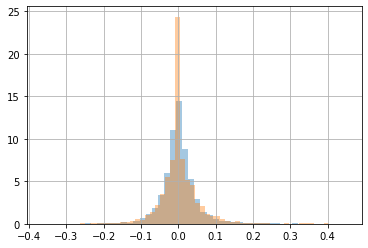

In [ ]:
df_t=df[df.tenure>0]
df_t['charge_increment']=df_t.eval('MonthlyCharges/(TotalCharges/tenure)-1')
axs=df_t.charge_increment.groupby(df_t.Churn).hist(density=1, alpha=.4,bins=50)

Not really a difference in charge increment from churn. Check other columns.



SeniorCitizen                   ... charge_increment                    
                min median      mean  ...           median      mean       max
Churn                                 ...                                     
No                0      0  0.128995  ...              0.0  0.001952  0.450628
Yes               0      0  0.254682  ...              0.0  0.003303  0.404548

[2 rows x 20 columns]

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/boxplot.py:375: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  **kwds,


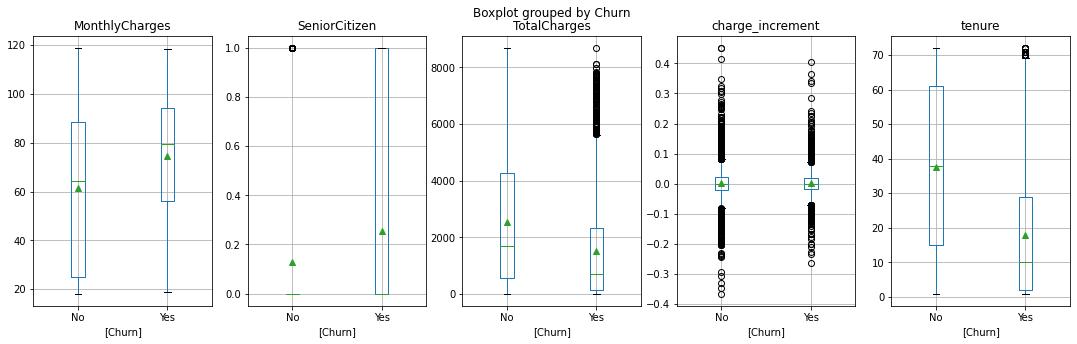

In [ ]:
display(df_t.groupby('Churn').agg(['min','median','mean','max']))

import matplotlib.pyplot as plt
fig, ax_new = plt.subplots(1,5, sharey=False,figsize=(18,5))
bp = df_t.boxplot(by="Churn",ax=ax_new, showmeans=True)

In [ ]:
from pandas import option_context

with option_context('display.max_colwidth', 100):
    displayable=df.columns.to_frame().applymap(lambda c: (df[c].nunique(),df[c].unique()))
    display(displayable)

,0
customerID,"(7043, [7590-VHVEG, 5575-GNVDE, 3668-QPYBK, 7795-CFOCW, 9237-HQITU, 9305-CDSKC, 1452-KIOVK, 6713..."
gender,"(2, [Female, Male])"
SeniorCitizen,"(2, [0, 1])"
Partner,"(2, [Yes, No])"
Dependents,"(2, [No, Yes])"
tenure,"(73, [1, 34, 2, 45, 8, 22, 10, 28, 62, 13, 16, 58, 49, 25, 69, 52, 71, 21, 12, 30, 47, 72, 17, 2..."
PhoneService,"(2, [No, Yes])"
MultipleLines,"(3, [No phone service, No, Yes])"
InternetService,"(3, [DSL, Fiber optic, No])"
OnlineSecurity,"(3, [No, Yes, No internet service])"


Redundant information:
- no internet service implies 6 other "boolean" columns have the value "no internet service"
  - OnlineSecurity	(3, [No, Yes, No internet service])
  - OnlineBackup	(3, [Yes, No, No internet service])
  - DeviceProtection	(3, [No, Yes, No internet service])
  - TechSupport	(3, [No, Yes, No internet service])
  - StreamingTV	(3, [No, Yes, No internet service])
  - StreamingMovies	(3, [No, Yes, No internet service])
- no phone service implies multiple lines to be non applicable

We have the following groups of columns:
- demographic information:
  - gender
  - age (senior boolean)
  - marital status (partner boolean)
  - people depending economically on them (dependents)
- Services 
  - phone
    - multiple lines
  - internet
    - online security
    - online backup
    - device protection (insurance)
    - tech support
    - streaming TV
    - movies
- Customer account information
  - tenure: months they’ve been a customer
  - contract time scope: 1 month, 1 year, 2 years
  - payment method
  - paperless billing
  - monthly charges
  - total charges (0 if tenure is 0)

## Feature Enginnering and Modelling

### Feature Encoding using ordinals

1. one-hot-encoding every non-ordered-categorical column

  - Payment Method:
    - Electronic check: 1000
    - Mailed check: 0100
    - Bank transfer (automatic): 0010
    - Credit card (automatic): 0001

2. encode numerically without extra columns where possible:

   - contract: monthly->1, yearly->12, 2 years -> 24
   - multiple lines: no phone service-> 0, No-> 1 , Yes-> 4
   - internet service: No/No internet Service->0, Yes->1

In [ ]:
import pandas as pd
#read
df=pd.read_csv('data.csv',index_col='customerID')
#fix total charges
df.TotalCharges=df.TotalCharges.replace(' ',0).astype(float)

#Translate contract timeframe into number of months
df.Contract=df.Contract.map({'Month-to-month':1,'One year':12,'Two year':24})
#replace PhoneService and MultipleLines by  PhoneLines as ordered categorical
df['PhoneLines']=df['MultipleLines'].map({'No phone service':0, 'No':1, 'Yes':4})
df=df.drop(['PhoneService','MultipleLines'],axis='columns')
#encode internet service as ordered categorical
df.InternetService=df.InternetService.map({'No':0,'DSL':1,'Fiber optic':2})
#keep only yes as a 1 from internet services
internet_services=['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
df[internet_services]=(df[internet_services]=='Yes').astype(int)
#encode genders as opposites -1,+1
df.gender=df.gender.map({'Female':-1,'Male':1})
#encode yes or no columns as 0,1
df=df.applymap({'No':0,'Yes':1}.get).fillna(df)
#one hot encode payment method
df=pd.get_dummies(df,columns=['PaymentMethod'],drop_first=False)

display(df.head(1))
#split target and features
target='Churn'
X=df.drop(target,axis='columns').astype('float')
y=df[target]

,gender,SeniorCitizen,Partner,Dependents,tenure,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,PhoneLines,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
customerID,,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,-1,0,1,0,1,1,0,1,0,0,0,0,1,1,29.85,29.85,0,0,0,0,1,0


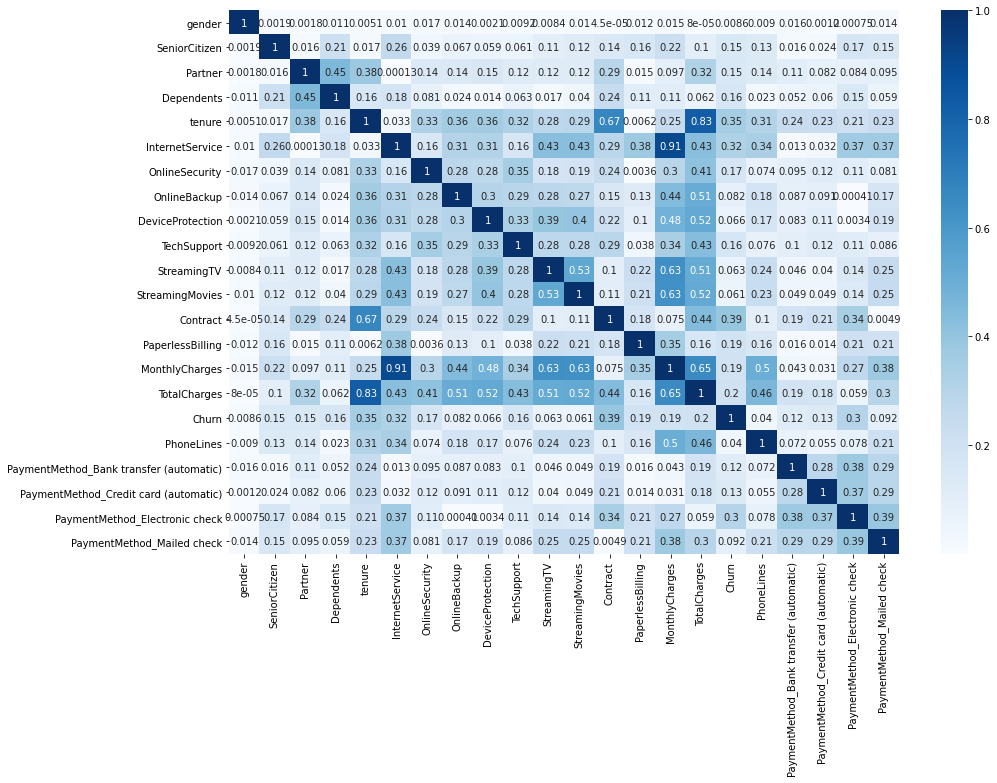

In [ ]:
import seaborn as sns

ax,fig=plt.subplots(figsize=(15,10))
sns.heatmap(df.astype(float).corr().abs(),cmap='Blues',annot=True)

Churn is mostly correlated (in magnitude) to:
- Contract duration: 0.39
- Tenure: 0.35
- Internet service: 0.32
- Electronic check payment 0.30

#### Logistic Regression 80.52% Accuracy

logit model


,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc
0,0.805197,0.805797,0.845308,0.847221


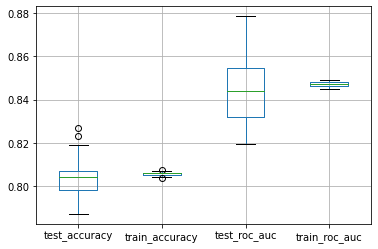

In [ ]:
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

print('logit model')
clf = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(penalty= 'l2' ,C = .1))])

from sklearn.model_selection import cross_validate

def plot_cross_validation(clf, X, y):
  results=cross_validate(pipe, X, y, scoring=['accuracy','roc_auc'],cv=14,return_train_score=True,return_estimator=True)
  clf=results.pop('estimator')[0]
  results=pd.DataFrame(results).filter(regex='^((?!time).)*$')
  results.plot(kind='box',grid=True)
  display(results.mean().to_frame().T)
  return clf

clf=plot_cross_validation(pipe,X,y)

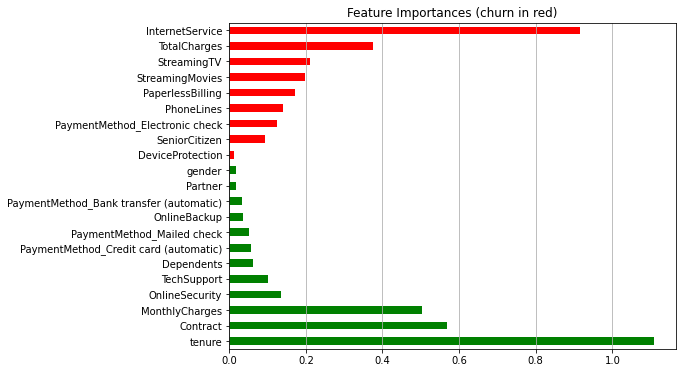

In [ ]:
logreg=clf[1]
feat_imp=pd.Series(data=logreg.coef_.flatten(),index=X.columns).sort_values()
color=feat_imp.ge(0).map({False:'green',True:'red'})
ax=feat_imp.abs().plot(kind='barh',grid=False,color=color,title='Feature Importances (churn in red)',figsize=(8,6))
ax.grid(True, which='major', axis='x', alpha=1)

Conclusions:

*   Customers with internet service are more likely to churn. However, only internet streaming services are the most indicative of churn, but contrary to tech support or online security. So customers inclined to leisure change more often, and those concerned about security stay. Device protection and online backup contradict this hypothesis, however.
*   The total accumulated charged to a customer indicates churn, but not the number of months of membership (tenure), so it has to do with monthly charges in the past. However, the charges of last month, monthlyCharges, is very indicative of staying. This requires more investigation.
*   The number of phone lines is indicative of churn.
*   Demographic information is not very relevant to churn, except for age, surprisingly associated to churn, and dependents, associated to stay.
*   Mailed check payment is associated to stay, probably because not very technology literate customers.
*   Longer contracts are associated with more staying.


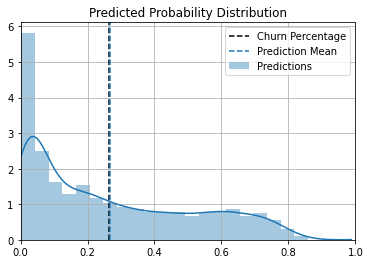

In [ ]:
import seaborn as sns

def plot_pred_distr(clf, X, y):
  yp=pd.Series(clf.predict_proba(X)[:,-1])  
  ax=sns.distplot(yp,label='Predictions ')
  ax.grid(True)
  ax.set_xlim((0,1))
  _=ax.set_title('Predicted Probability Distribution')
  ax.axvline(y.mean(),label='Churn Percentage',linestyle='--',c='k')
  ax.axvline(yp.mean(),label='Prediction Mean',linestyle='--')
  _=ax.legend()

plot_pred_distr(clf, X, y)

#### Sklearn MLP: 79.8% Accuracy

Check that a Multi-Layer Perceptron of 1 neuron hidden layer with logistic acivation is exacly a logistic regression classifier, except for the way the loss is optimized, not with a closed formula solution but by gradient descent.

Results are just a bit worse.

,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc
0,0.798382,0.801254,0.84183,0.844485


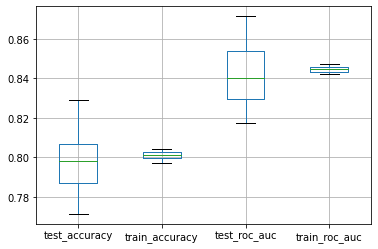

In [ ]:
from sklearn.neural_network import MLPClassifier

clf = Pipeline([('scaler', StandardScaler()), 
                 ('lr', MLPClassifier(random_state=1, hidden_layer_sizes=1,activation='logistic', max_iter=1000, verbose=0))])

clf = plot_cross_validation(clf,X,y)

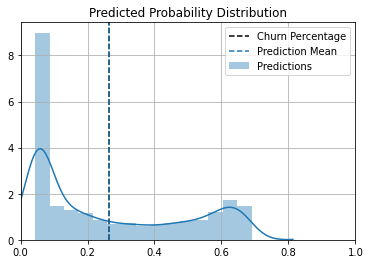

In [ ]:
plot_pred_distr(clf, X, y)

Create a Multilayer Perceptron with just one hidden layer with 11 neurons, which starts to overfit.

,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc
0,0.798808,0.810341,0.843072,0.856878


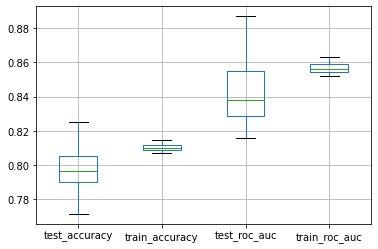

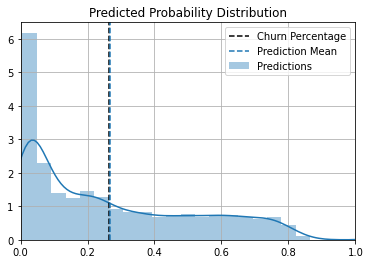

In [ ]:
clf = Pipeline([('scaler', StandardScaler()), 
                 ('lr', MLPClassifier(random_state=1, hidden_layer_sizes=(11),activation='logistic', max_iter=1000, verbose=0))])

clf = plot_cross_validation(clf,X,y); plt.show()
plot_pred_distr(clf, X, y)

#### Random Forest Classifier

We get surprisingly similar results with every classifier.

,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc
0,0.796107,0.805066,0.846023,0.859383


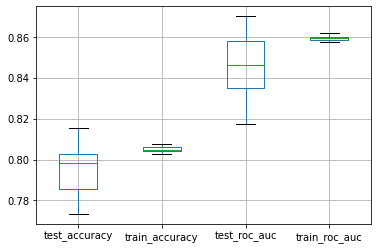

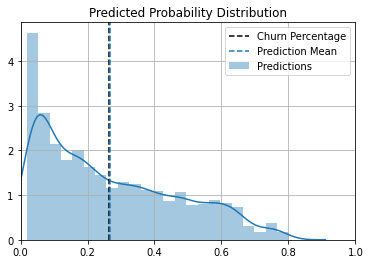

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=500, max_depth=5)

clf = plot_cross_validation(clf,X,y); plt.show()
plot_pred_distr(clf, X, y)

Nearest neighbors

,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc
0,0.783474,0.813585,0.788453,0.864471


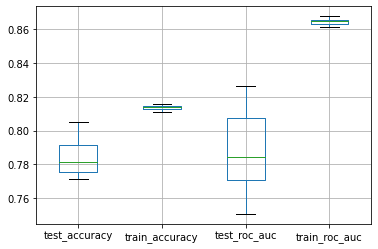

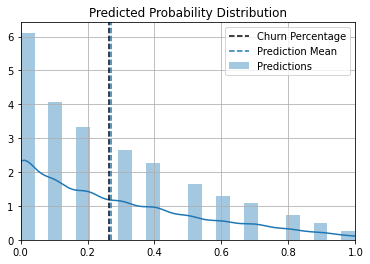

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=10)

clf = plot_cross_validation(clf,X,y); plt.show()
plot_pred_distr(clf, X, y)

So far the logistic regression is the best model, so we discard the rest and compare encoding methods.

### Plain one-hot encoding: 80.39 % Accuracy
What if we give the logistic model everything with plain one hot encoding, only dropping one for binary variables?

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
customerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,1,29.85,29.85,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0


logit model


,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc
0,0.803919,0.805481,0.845527,0.847743


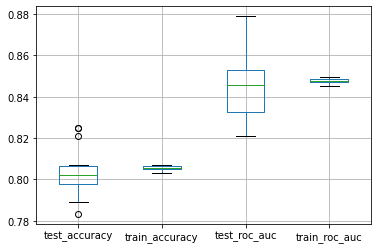

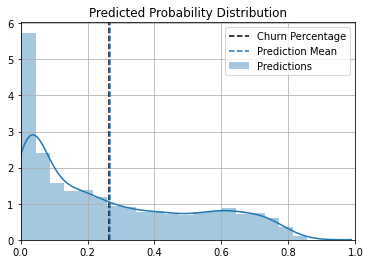

In [ ]:
#read
df=pd.read_csv(fname,index_col='customerID')
#fix total charges
df.TotalCharges=df.TotalCharges.replace(' ',0).astype(float)
#one hot encoding
for c in df.select_dtypes(exclude='number').columns:
    df=pd.get_dummies(df,columns=[c],drop_first=df[c].nunique()==2)
display(df.head(1))
#split target and features
target='Churn_Yes'
X=df.drop(target,axis='columns').values
y=df[target].values

clf = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(penalty= 'l2' ,C = .1))])
clf = plot_cross_validation(clf,X,y); plt.show()
plot_pred_distr(clf, X, y)

About the same, just 0.1% less accuracy.

#### One hot encoding dropping one: 80.44% Accuracy
What if we always drop the one column from one hot encoding

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
customerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,1,29.85,29.85,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc
0,0.804487,0.805557,0.845488,0.847721


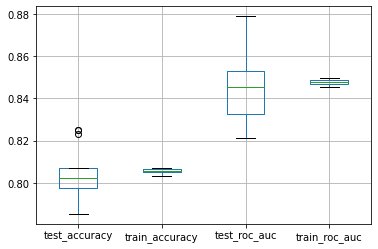

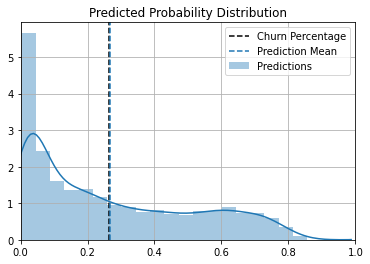

In [ ]:
#read
df=pd.read_csv(fname,index_col='customerID')
#fix total charges
df.TotalCharges=df.TotalCharges.replace(' ',0).astype(float)
#one hot encoding
for c in df.select_dtypes(exclude='number').columns:
    df=pd.get_dummies(df,columns=[c],drop_first=True)
display(df.head(1))
#split target and features
target='Churn_Yes'
X=df.drop(target,axis='columns').values
y=df[target].values

clf = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(penalty= 'l2' ,C = .1))])
clf = plot_cross_validation(clf,X,y); plt.show()
plot_pred_distr(clf, X, y)

Almost exactly the same result, 80.45% accuracy. Just between plain one hot encoding and using ordinals, but we could say it is better to drop one.

### Neural Network architectures with Keras

- No hidden layers (logistic regression)
- Tree: Connect first variables of same groups
- Multilayer Perceptron

In [ ]:
import pandas as pd
#read
df=pd.read_csv('data.csv',index_col='customerID')
#fix total charges
df.TotalCharges=df.TotalCharges.replace(' ',0).astype(float)
#one hot encoding
for c in df.select_dtypes(exclude='number').columns:
    df=pd.get_dummies(df,columns=[c],drop_first=True)
display(df.head(1))
#split target and features
target='Churn_Yes'
X=df.drop(target,axis='columns')
y=df[target].values

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
customerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,1,29.85,29.85,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


In [ ]:
from sklearn.preprocessing import StandardScaler

std=StandardScaler()
X=std.fit_transform(X)

#### No hidden Layers Perceptron

In [ ]:
from keras.optimizers import Adam
from keras.layers import Input
from keras.layers.core import Dense
from keras.models import Model
from keras.metrics import AUC
from keras.regularizers import L2

def compile_model(model,lr=1e-4):
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr),metrics=['accuracy', AUC(name='auc')])

def hidden(input_layer):
    return Dense(units=1,activation='sigmoid',activity_regularizer=L2(1e-1))(input_layer)

def build_model():
    input_layer=Input((X.shape[1],),name='raw_input')
    
    output=hidden(input_layer)
    
    model = Model(inputs=input_layer, outputs=output)
    compile_model(model)
#     model.summary()
    return model

model=build_model()
model.summary()

Model: "functional_410"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
raw_input (InputLayer)       [(None, 30)]              0         
_________________________________________________________________
dense_121 (Dense)            (None, 1)                 31        
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


,loss,accuracy,auc,val_loss,val_accuracy,val_auc
94,0.4301,0.8045,0.8442,0.4465,0.8042,0.8339


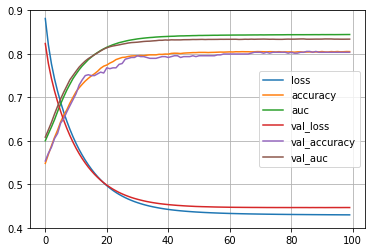

In [ ]:
model=build_model()
model.fit(X,y,
          validation_split=1/14,
          batch_size=15,
          epochs=100,
          shuffle=True,
          verbose=0,
          )
history=pd.DataFrame(model.history.history)
history.plot(grid=True, ylim=(0.4,.9))
history.rolling(10).mean().sort_values(by='val_accuracy',ascending=False).head(1).round(4)

In [ ]:
import numpy as np

class KerasAdapter():
    """Wrapper to adapt a keras binary classification model to sklearn.model_selection.cross_validate"""
    def __init__(self,build_model,epochs=100,verbose=2,batch_size=15):
        self.model_builder=build_model
        self.epochs=epochs
        self.verbose=verbose
        self.batch_size=batch_size
        self.model=build_model()
    def fit(self,X_train,y_train):
        self.model.fit(X_train,y_train,
                       verbose=self.verbose,
                       batch_size=15,
                       epochs=self.epochs,
                       shuffle=True,
                       )
    def predict_proba(self,X):
        p1 = self.model(X, training=False)
        p0 = 1-p1
        return np.hstack((p0,p1))
    def predict(self,X):
        return np.around(self.predict_proba(X)[:,-1])
    def get_params(self,deep=True):
        return {'epochs':self.epochs,'build_model':self.build_model,'verbose':self.verbose,'batch_size':self.batch_size}

from IPython.display import clear_output
from sklearn.model_selection import cross_validate

def keras_cross_validation(build_model,epochs=100,cv=14,verbose=2):
  clf=KerasAdapter(build_model,epochs, verbose)
  # clf = KerasClassifier(build_fn=build_model, epochs=epochs, batch_size=15, verbose=0)
  # scores = cross_validate(clf, X, y, scoring=['accuracy','roc_auc'],return_train_score=True,cv=cv)
  scores = cross_validate(clf, X, y, scoring=['accuracy'],return_train_score=True,cv=cv)
  clear_output(wait=True)
  results=pd.DataFrame(scores).drop(['fit_time','score_time'],axis='columns')
  results.plot(kind='box',grid=True,showmeans=True)
  display(results.mean().to_frame().T)

,test_accuracy,train_accuracy
0,0.802924,0.804803


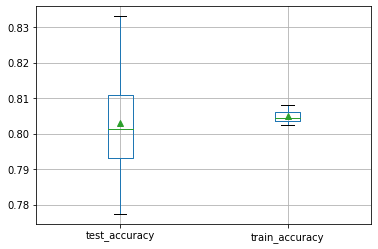

In [ ]:
keras_cross_validation(build_model,95,verbose=0)

#### Tree Architecture

Make subnetworks for every column branch, and then one from the concatenation of branch outputs.

In [ ]:
#tree architecture
from itertools import chain

X=df.drop(target,axis='columns')

groups={
    'demographics':['gender','Senior','Partner','Dependents'],
    'contract':['tenure','Charges','Contract','Pay','Paper'],
    'services':['Lines','Phone','Internet','Online','Tech','Device','Streaming']
        }
total_cols=0
for g in groups:
  groups[g]=set(chain(*[X.filter(like=like).columns.tolist() for like in groups[g]]))
  total_cols+=len(groups[g])
  print(groups[g])

assert(total_cols==len(X.columns))

#reorder columns to groups
X=X[chain(*groups.values())]

from keras.layers.core import Lambda
def select_range(layer,start=None,end=None,name=None):
  return Lambda(lambda x: x[:,start:end],name=name)(layer)

from keras.layers.core import Dense
from keras.layers import Concatenate
from keras.regularizers import L2

def hidden(input_layer):
  start=0
  group_layers=[]
  for name in groups:
    n_cols=len(groups[name])
    end=start+n_cols
    group_input = select_range(input_layer, start, end, name+'_input')
    layer=Dense(units=15,activation='relu',activity_regularizer=L2(1e-2),name=name+'_ouput')(group_input)
    group_layers.append(layer)
    start += n_cols
  merged=Concatenate(name='merged')(group_layers)
  output=Dense(units=1,activation='sigmoid',name='ouput')(merged)
  return output

std=StandardScaler()
X=std.fit_transform(X)

model=build_model()
model.summary()

{'Dependents_Yes', 'gender_Male', 'SeniorCitizen', 'Partner_Yes'}
{'tenure', 'Contract_Two year', 'PaymentMethod_Mailed check', 'TotalCharges', 'Contract_One year', 'PaymentMethod_Credit card (automatic)', 'PaperlessBilling_Yes', 'PaymentMethod_Electronic check', 'MonthlyCharges'}
{'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'StreamingTV_No internet service', 'TechSupport_No internet service', 'MultipleLines_No phone service', 'OnlineBackup_No internet service', 'DeviceProtection_Yes', 'TechSupport_Yes', 'DeviceProtection_No internet service', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'MultipleLines_Yes', 'InternetService_No', 'StreamingTV_Yes', 'OnlineSecurity_No internet service', 'InternetService_Fiber optic', 'PhoneService_Yes'}
Model: "functional_268"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
raw_input (InputL

,loss,accuracy,auc,val_loss,val_accuracy,val_auc
33,0.4455,0.805,0.8472,0.4608,0.8105,0.8366


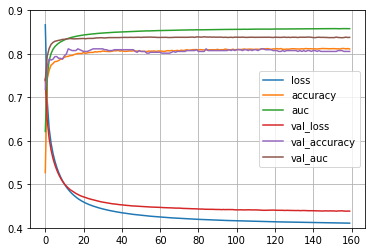

In [ ]:
model=build_model()
model.fit(X,y,
          validation_split=1/14,
          batch_size=15,
          epochs=160,
          shuffle=True,
          verbose=2,
          )
history=pd.DataFrame(model.history.history)
history.plot(grid=True, ylim=(0.4,.9))
history.rolling(10).mean().sort_values(by='val_accuracy',ascending=False).head(1).round(4)

,test_accuracy,train_accuracy
0,0.806049,0.809587


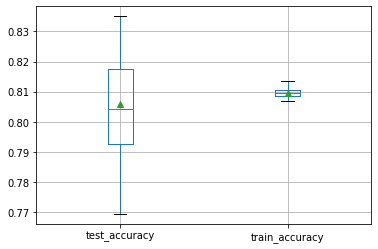

In [ ]:
keras_cross_validation(build_model,80,verbose=0)

The tree architecture does a bit better when increasing the number of output neurons of each branch of columns to 15, but still not a lot of difference.

Let's add more structure inside each branch: duplicate the branch input number neurons and then back to the input number of neurons before concatenating branches. Also add a hidden layers of size 30 and 15 after concatenation.

In [ ]:
def hidden(input_layer):
  start=0
  group_layers=[]
  for name in groups:
    n_cols=len(groups[name])
    end=start+n_cols
    group_input = select_range(input_layer, start, end, name+'_input')
    hidden_layer=Dense(units=2*n_cols,activation='relu',activity_regularizer=L2(1e-1),name=name+'_hidden')(group_input)
    layer=Dense(units=n_cols,activation='relu',activity_regularizer=L2(1e-1),name=name+'_output')(hidden_layer)
    group_layers.append(layer)
    start += n_cols
  merged=Concatenate(name='merged')(group_layers)
  # output=Dense(units=1,activation='sigmoid',name='ouput',activity_regularizer=L2(1e-1))(merged)
  merged_hidden=Dense(units=30,activation='sigmoid',name='merged_hidden',activity_regularizer=L2(1e-2))(merged)
  merged_hidden=Dense(units=15,activation='sigmoid',name='merged_hidden_1',activity_regularizer=L2(1e-2))(merged_hidden)
  output=Dense(units=1,activation='sigmoid',name='ouput',activity_regularizer=L2(1e-2))(merged_hidden)
  return output

,loss,accuracy,auc,val_loss,val_accuracy,val_auc
39,0.4895,0.8003,0.8477,0.512,0.8093,0.8216


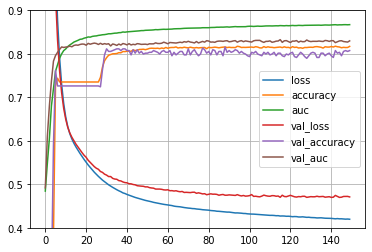

In [ ]:
model=build_model()
model.fit(X,y,
          validation_split=1/14,
          batch_size=15,
          epochs=150,
          shuffle=True,
          verbose=2,
          )
clear_output(wait=True)
history=pd.DataFrame(model.history.history)
history.plot(grid=True, ylim=(0.4,.9))
history.rolling(10).mean().sort_values(by='val_accuracy',ascending=False).head(1).round(4)

,test_accuracy,train_accuracy
0,0.766722,0.764785


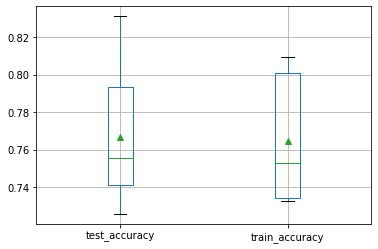

In [ ]:
keras_cross_validation(build_model,80,verbose=0)

Too noisy!

#### One Big Hidden Layer

Let's finally try a multilayer perceptron with only one hidden layer of 50 neurons.

,loss,accuracy,auc,val_loss,val_accuracy,val_auc
50,0.4358,0.8073,0.8615,0.4552,0.8167,0.8426


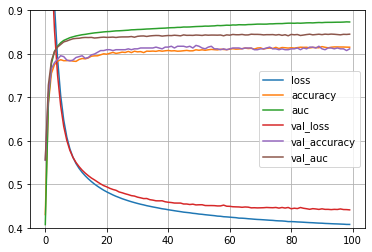

In [ ]:
def hidden(input_layer):
   d= Dense(units=50,activation='relu',activity_regularizer=L2(1e-1))(input_layer)
   output=Dense(units=1,activation='sigmoid',name='ouput')(d)
   return output

model=build_model()
model.fit(X,y,
          validation_split=1/14,
          batch_size=15,
          epochs=100,
          shuffle=True,
          verbose=0,
          )

history=pd.DataFrame(model.history.history)
history.plot(grid=True, ylim=(0.4,.9))
history.rolling(10).mean().sort_values(by='val_accuracy',ascending=False).head(1).round(4)

,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc
0,0.803065,0.811717,0.84291,0.86768


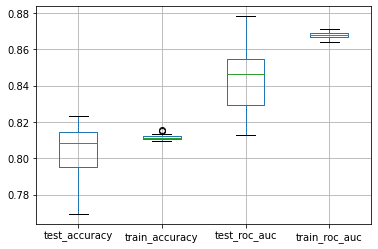

In [ ]:
keras_cross_validation(build_model,epochs=60)

The combination of 50 neurons in a hidden layer and a strong regularization seems to improve results significantly more than our tree architecture.

#### Multi-Layer Perceptron

Try a second hidden layer of 15 neurons.

,loss,accuracy,auc,val_loss,val_accuracy,val_auc
97,0.4892,0.8081,0.8628,0.5046,0.8181,0.8415


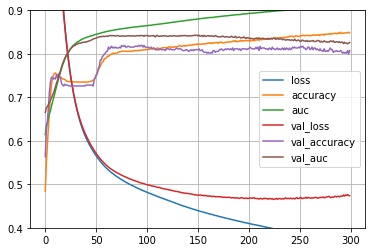

In [ ]:
def hidden(input_layer):
    d=input_layer
    for units in [50,15]:
        d = Dense(units=units, activation='relu',activity_regularizer=L2(1e-1))(d)
    return Dense(units=1,activation='sigmoid')(d)

model=build_model()
model.fit(X,y,
          validation_split=1/14,
          batch_size=100,
          epochs=300,
          shuffle=True,
          verbose=0,
          )

history=pd.DataFrame(model.history.history)
history.plot(grid=True, ylim=(0.4,.9))
history.rolling(10).mean().sort_values(by='val_accuracy',ascending=False).head(1).round(4)

The crossvalidation algorithm doesn't do very well due to unstability for a fixed number of epochs

,test_accuracy,train_accuracy,test_roc_auc,train_roc_auc
0,0.783047,0.851093,0.815683,0.916096


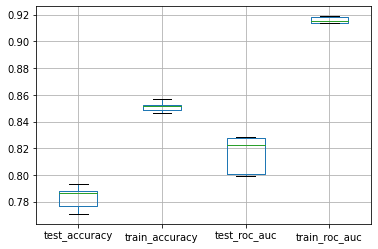

In [ ]:
clf=KerasAdapter(model,epochs=90)

scores = cross_validate(clf, X, y, scoring=['accuracy','roc_auc'],return_train_score=True)
results=pd.DataFrame(scores).drop(['fit_time','score_time'],axis='columns')
results.plot(kind='box',grid=True)
results.mean().to_frame().T